In [1]:
from dotenv import load_dotenv
import os
import json
import kaggle
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.stats import pearsonr

load_dotenv(dotenv_path="../.env")
KAGGLE_USERNAME = os.environ.get("KAGGLE_USERNAME", "")
KAGGLE_KEY = os.environ.get("KAGGLE_KEY", "")
RAW_DATA_PATH = os.environ.get("RAW_DATA_PATH", "")

In [2]:
RAW_DATA_PATH

'../data/raw'

In [3]:
submission_data = pd.read_csv(RAW_DATA_PATH + "//sample_submission.csv")
test_data = pd.read_csv(RAW_DATA_PATH + "//test.csv")
train_data = pd.read_csv(RAW_DATA_PATH + "//train.csv")

# Overview Variables

In [4]:
def calc_no_of_outlier(input_values):
    
    input_values = input_values.astype("float")
    
    q_1 = np.quantile(input_values, 0.25)
    q_3 = np.quantile(input_values, 0.75)
    IQR = q_3 - q_1
    upper_limit = q_3 + IQR * 1.5
    lower_limit = q_1 - IQR * 1.5
    
    mask = ((input_values > upper_limit)|(input_values < lower_limit))
    outlier = np.where(mask, input_values, "outlier")     
    
    return outlier
######################

relevant_cols = ["feat", "dtype", "count", "N/A", "nunique", "outliers", "min", "max", "mode / mean"]
df_info = pd.DataFrame(columns = relevant_cols)
agg_data = np.array(relevant_cols)

for col in train_data.columns.to_list():
    data = np.array([])
    data = np.append(data, col)
    data = np.append(data, train_data[col].dtype)
    data = np.append(data, train_data[col].shape[0])
    data = np.append(data, train_data[col].isnull().sum())
    data = np.append(data, train_data[col].nunique())
    if train_data[col].dtype=="object":
        data = np.append(data, "xxx")
        data = np.append(data, "xxx")
        data = np.append(data, "xxx")
        data = np.append(data, train_data[col].value_counts().index[0])
        
    else:
        data = np.append(data, len(set(calc_no_of_outlier(train_data[col].values))))
        data = np.append(data, np.min(train_data[col]))
        data = np.append(data, np.max(train_data[col]))
        data = np.append(data, np.round(np.mean(train_data[col]),2))
    
    agg_data = np.vstack((agg_data, data))
    
df_info = pd.DataFrame(agg_data).iloc[1:].rename({k:v for k, v in enumerate(relevant_cols)}, axis = 1)

df_info.sort_values(by="dtype")

,feat,dtype,count,N/A,nunique,outliers,min,max,mode / mean
1,id,int64,1235,0,1235,1,0,1234,617.0
27,lesion_3,int64,1235,0,2,2,0,2209,3.58
26,lesion_2,int64,1235,0,4,4,0,3112,14.61
4,hospital_number,int64,1235,0,255,30,521399,5305129,954500.4
25,lesion_1,int64,1235,0,57,26,0,41110,3832.5
5,rectal_temp,float64,1235,0,43,11,35.4,40.8,38.2
6,pulse,float64,1235,0,50,2,30.0,184.0,79.57
7,respiratory_rate,float64,1235,0,37,9,8.0,96.0,30.05
23,abdomo_protein,float64,1235,0,54,6,0.1,10.1,3.29
21,total_protein,float64,1235,0,83,34,3.5,89.0,21.39


In [5]:
numerical_feats = [feat for feat in df_info[df_info["dtype"]!="object"]["feat"] if (feat in df_info[df_info["dtype"]!="object"]["feat"].values and feat not in ["id"])]
categorical_feats = [feat for feat in df_info["feat"] if (feat not in numerical_feats and not feat in ["id"])]

print(f"This are the metric / numerical features: {numerical_feats}")
print(f"\nThis are the categorical features: {categorical_feats}")

This are the metric / numerical features: ['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein', 'lesion_1', 'lesion_2', 'lesion_3']

This are the categorical features: ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data', 'outcome']


Summary:
* There are 1.235 data points
* There are some columns exhibiting missing data
* There are just a few outlier suspicions <br>
---------------------------------------------------------------------------------------------
* relevante variable "outcome"
* 12 numerical / 17 categorical features
* What is the unique identifier of each row in the data? There is one column called "ID"
---------------------------------------------------------------------------------------------
1.  surgery: <br>
     1 = Yes, it had surgery
     2 = It was treated without surgery <br>
2.  Age: <br>
     1 = Adult horse
     2 = Young (< 6 months) <br>
3.  Hospital Number: <br>
     -  numeric id
     - the case number assigned to the horse (may not be unique if the horse is treated > 1 time) <br>
4.  rectal temperature: <br>
     - linear
     - in degrees celsius.
     - An elevated temp may occur due to infection.
     - temperature may be reduced when the animal is in late shock
     - normal temp is 37.8
     - this parameter will usually change as the problem progresses, eg. may start out normal, then become elevated because of the lesion, passing back through the normal range as the horse goes into shock <br>
5.  pulse: <br> 
     - linear
     - the heart rate in beats per minute
     - is a reflection of the heart condition: 30 -40 is normal for adults
     - rare to have a lower than normal rate although athletic horses may have a rate of 20-25
     - animals with painful lesions or suffering from circulatory shock may have an elevated heart rate
6.  respiratory rate: <br>
     - linear
     - normal rate is 8 to 10
     - usefulness is doubtful due to the great fluctuations
7.  temperature of extremities: <br>
     - a subjective indication of peripheral circulation
     - possible values:
          1 = Normal
          2 = Warm
          3 = Cool
          4 = Cold
     - cool to cold extremities indicate possible shock
     - hot extremities should correlate with an elevated rectal temp.
8.  peripheral pulse: <br>
     - subjective
     - possible values are:
          1 = normal
          2 = increased
          3 = reduced
          4 = absent
     - normal or increased p.p. are indicative of adequate circulation while reduced or absent indicate poor perfusion
9.  mucous membranes: <br>
     - a subjective measurement of colour
     - possible values are:
          1 = normal pink
          2 = bright pink
          3 = pale pink
          4 = pale cyanotic
          5 = bright red / injected
          6 = dark cyanotic
     - 1 and 2 probably indicate a normal or slightly increased circulation
     - 3 may occur in early shock
     - 4 and 6 are indicative of serious circulatory compromise
     - 5 is more indicative of a septicemia
10. capillary refill time: <br>
     - a clinical judgement. The longer the refill, the poorer the circulation
     - possible values
          1 = < 3 seconds
          2 = >= 3 seconds
11. pain - a subjective judgement of the horse's pain level: <br>
     - possible values:
          1 = alert, no pain
          2 = depressed
          3 = intermittent mild pain
          4 = intermittent severe pain
          5 = continuous severe pain
     - should NOT be treated as a ordered or discrete variable!
     - In general, the more painful, the more likely it is to require surgery
     - prior treatment of pain may mask the pain level to some extent
12. peristalsis: <br>                              
     - an indication of the activity in the horse's gut. As the gut becomes more distended or the horse becomes more toxic, the activity decreases
     - possible values:
          1 = hypermotile
          2 = normal
          3 = hypomotile
          4 = absent
13. abdominal distension: <br>
     - An IMPORTANT parameter.
     - possible values
          1 = none
          2 = slight
          3 = moderate
          4 = severe
     - an animal with abdominal distension is likely to be painful and have reduced gut motility.
     - a horse with severe abdominal distension is likely to require surgery just tio relieve the pressure
14. nasogastric tube: <br>
     - this refers to any gas coming out of the tube
     - possible values:
          1 = none
          2 = slight
          3 = significant
     - a large gas cap in the stomach is likely to give the horse discomfort
15. nasogastric reflux: <br>
     - possible values (1-6: acidic, 7: neutral, 8-12: alkaline)
          1 = none
          2 = > 1 liter
          3 = < 1 liter
     - the greater amount of reflux, the more likelihood that there is some serious obstruction to the fluid passage from the rest of the intestine
16. nasogastric reflux PH: <br>
     - linear
     - scale is from 0 to 14 with 7 being neutral
     - normal values are in the 3 to 4 range
17. rectal examination - feces: <br>
     - possible values
          1 = normal
          2 = increased
          3 = decreased
          4 = absent
     - absent feces probably indicates an obstruction
18. abdomen: <br>
     - possible values
          1 = normal
          2 = other
          3 = firm feces in the large intestine
          4 = distended small intestine
          5 = distended large intestine
     - 3 is probably an obstruction caused by a mechanical impaction and is normally treated medically
     - 4 and 5 indicate a surgical lesion
19. packed cell volume: <br>
     - linear
     - the # of red cells by volume in the blood
     - normal range is 30 to 50. The level rises as the circulation becomes compromised or as the animal becomes dehydrated.
20. total protein:<br>
     - linear
     - normal values lie in the 6-7.5 (gms/dL) range
     - the higher the value the greater the dehydration
21. abdominocentesis appearance: <br>
     - a needle is put in the horse's abdomen and fluid is obtained from
          the abdominal cavity
     - possible values:
          1 = clear
          2 = cloudy
          3 = serosanguinous
     - normal fluid is clear while cloudy or serosanguinous indicates a compromised gut
22. abdomcentesis total protein: <br>
          - linear
          - the higher the level of protein the more likely it is to have a compromised gut. Values are in gms/dL
23. outcome
     - what eventually happened to the horse?
     - possible values:
          1 = lived
          2 = died
          3 = was euthanized
24. surgical lesion?
     - retrospectively, was the problem (lesion) surgical?
     - all cases are either operated upon or autopsied so that this value and the lesion type are always known
     - possible values:
          1 = Yes
          2 = No
25. 26, 27. type of lesion
     - first number is site of lesion
          1 = gastric
          2 = sm intestine
          3 = lg colon
          4 = lg colon and cecum
          5 = cecum
          6 = transverse colon
          7 = retum/descending colon
          8 = uterus
          9 = bladder
          11 = all intestinal sites
          00 = none
     - second number is type
          1 = simple
          2 = strangulation
          3 = inflammation
          4 = other
     - third number is subtype
          1 = mechanical
          2 = paralytic
          0 = n/a
     - fourth number is specific code
          1 = obturation
          2 = intrinsic
          3 = extrinsic
          4 = adynamic
          5 = volvulus/torsion
          6 = intussuption
          7 = thromboembolic
          8 = hernia
          9 = lipoma/slenic incarceration
          10 = displacement
          0 = n/a
28. cp_data
     - is pathology data present for this case?
          1 = Yes
          2 = No
     - this variable is of no significance since pathology data is not included or collected for these cases

###################### <br>
Notes

* pulse: normal rate would be 30 - 40 <br>
    => why 79 on average? why 184 at max? Were the horses not at rest?
* respiratory_rate: normal rate would be at 10-15 respirations / minute <br>
    ==> why 30 on average? why 96 at max? 


    



good information: https://www.vet.cornell.edu/animal-health-diagnostic-center/laboratories/clinical-pathology/reference-intervals/chemistry

---------------------------------------------------------------------------------------------

Hypotheses:
* data points from a respective hospital have influence on the outcome

# First Look

## Categorical data

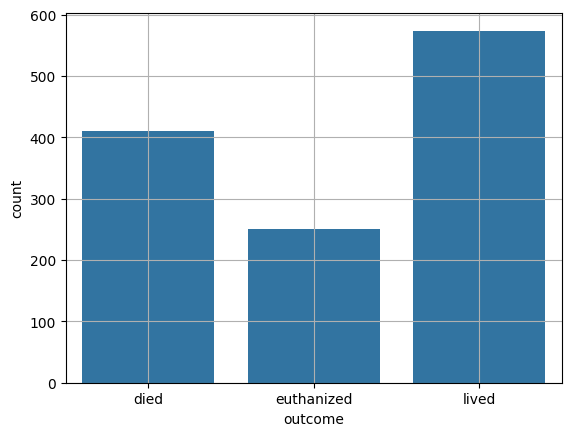

In [6]:
ax = sns.countplot(data = train_data, x = "outcome")
ax.grid()

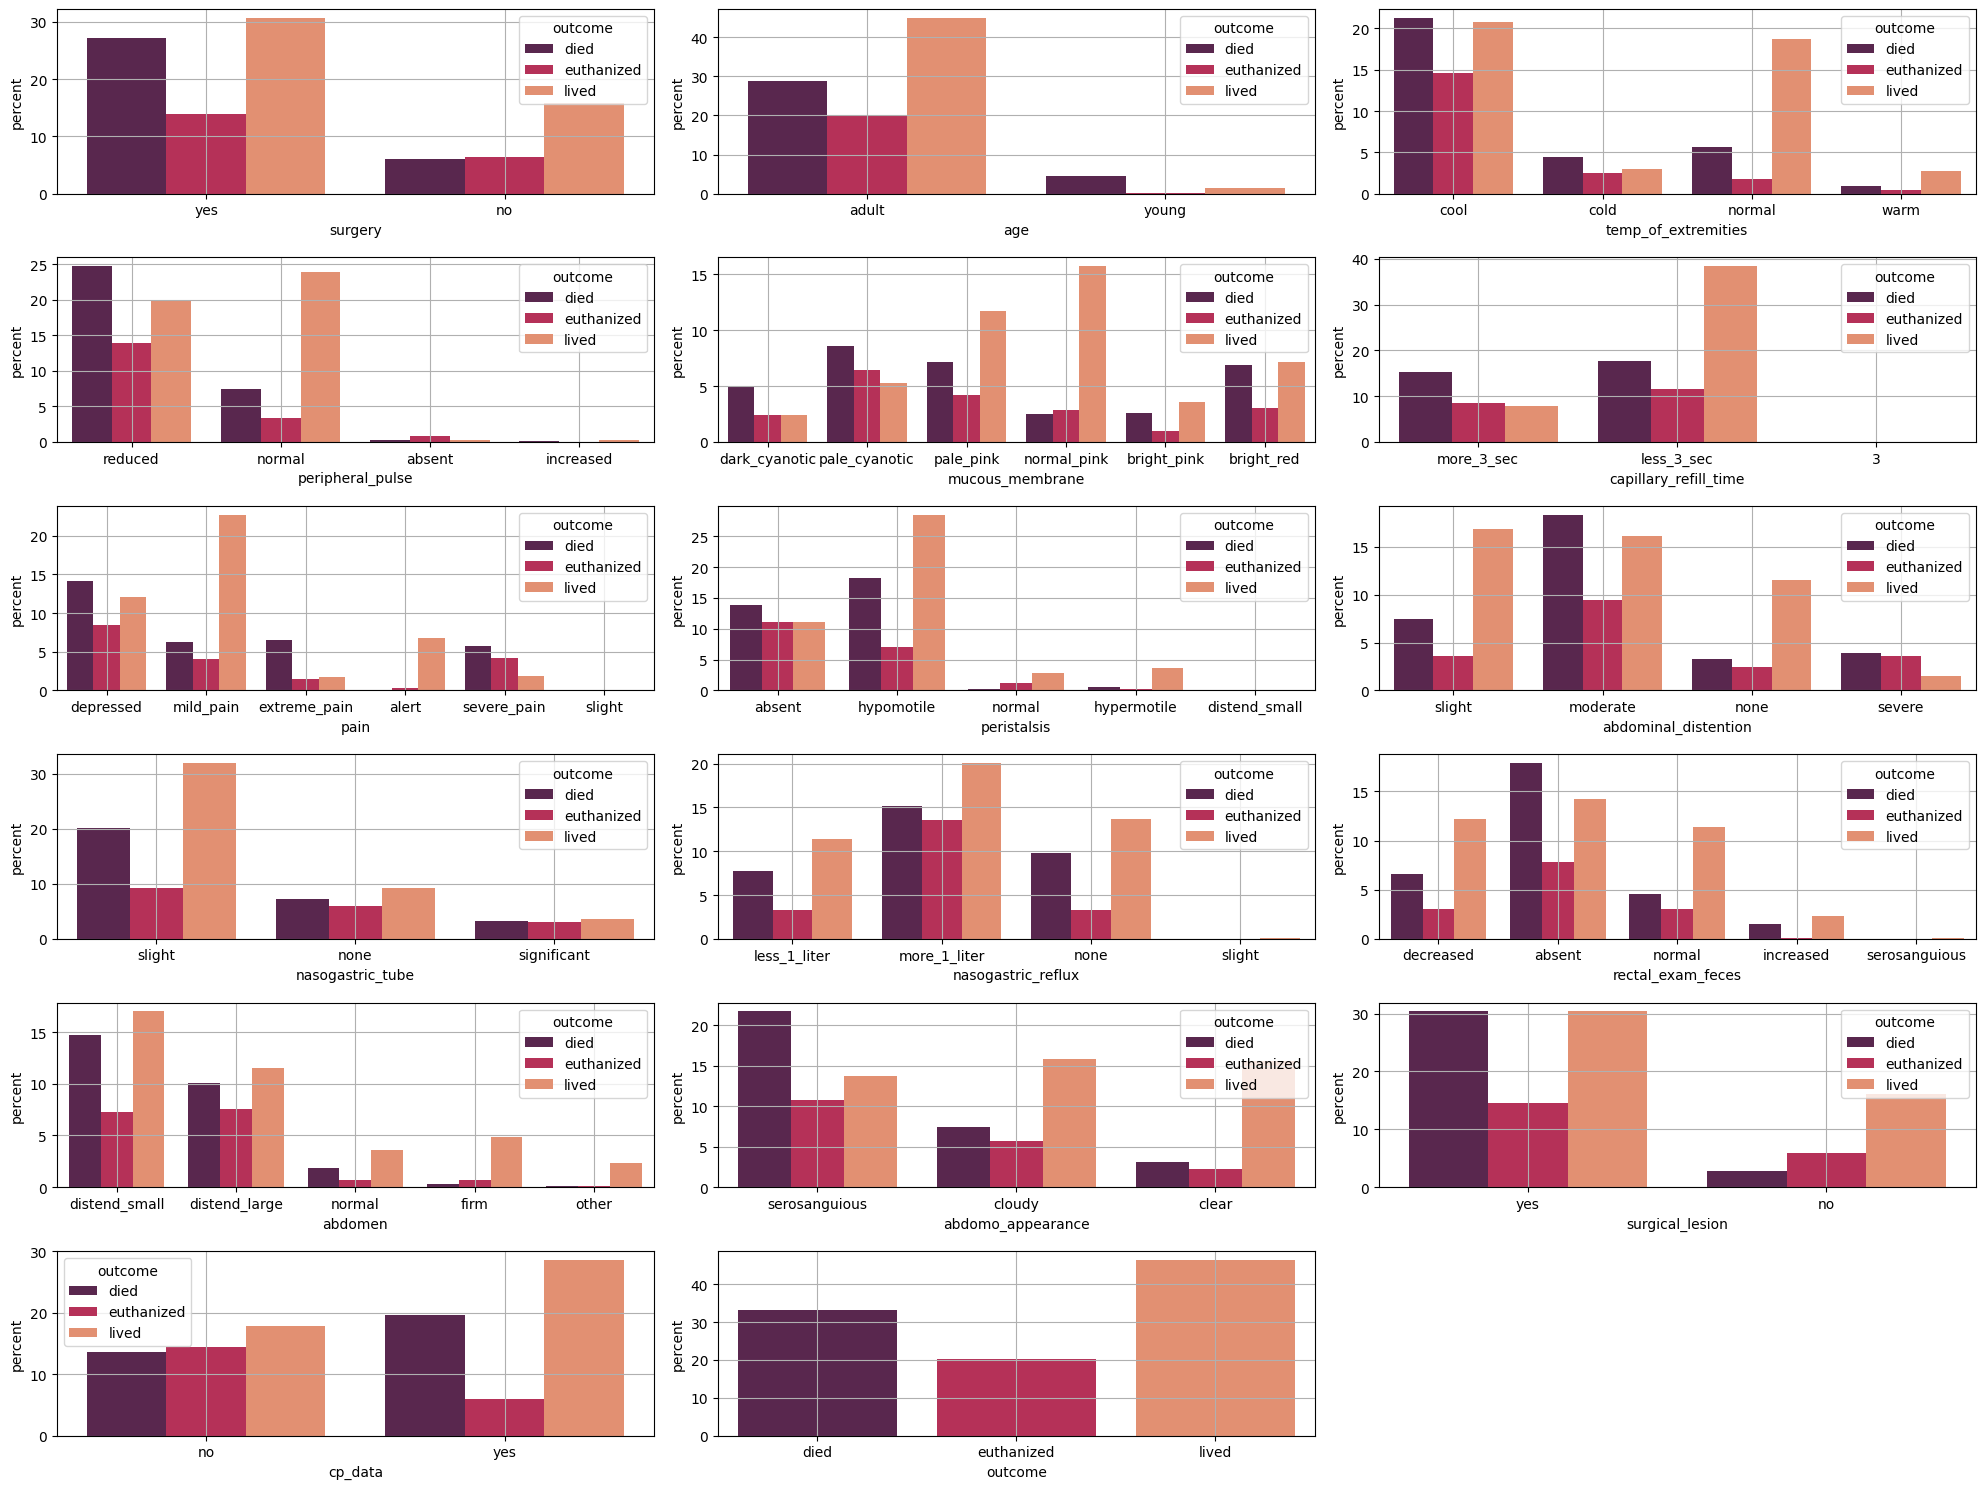

In [7]:
fig, sub = plt.subplots(6,3,figsize=(20,15))
sub_arr = sub.flatten()
feats = df_info[df_info["dtype"] == "object"]["feat"].values

for i, sub_plot in enumerate(sub_arr):
     
    if i<len(categorical_feats):
        sns.countplot(
            data = train_data,
            x = categorical_feats[i],
            hue = "outcome",
            ax = sub_plot,
            palette = "rocket",
            stat = "percent"
        )
        
        sub_plot.grid()        

    else:
        sub_plot.set_visible(False)
    
fig.tight_layout()    
    

Summary<br>
* surgery:<br>
    - when no, high chance that horse lives
    - when yes, quite equal chance that horse died / to lived
* age: <br>
    - very low number of young horses
* temp_of_extremities:
    - if "normal" high chance for the horse to live
    - if "cool" / "cold" -> quite equal chance for the horse to die/live
* peripheral_pulse:
    - if "normal" high chance for the horse to live
    - if "reduced" quite equal chance for the horse to die/live
* mucous_membrane:
    - if "normal_pink"/"pale_pink" quite high chance to live
* capillary_refill_time:
    - if "less_3_sec" => high chance to live
* pain:
    - if mild_pain => high chance to live
* peristalsis:
    - if hypomotile => higher chance to live
* abdominal_distention:
    - if sligth / none => high chance to live
* nasogastric_tube:
    - if "slight" => higher chance to live, rest quite equal chance
* nasogastric_reflux:
    - if "more_1_liter" / "none" => higher chance to live
* rectal_exam_feces:
    - if "decreased" / "normal" => higher chance to live
* abdomen:
    - quite equal chance in all values
* abdomo_appearance:
    - if "cloudy"/"clear" => higher chance to live
* surgical_lesion:
    - if "no" => higher chance to live
* cp_data:
    - if "yes" => higher chance to live

## Numerical

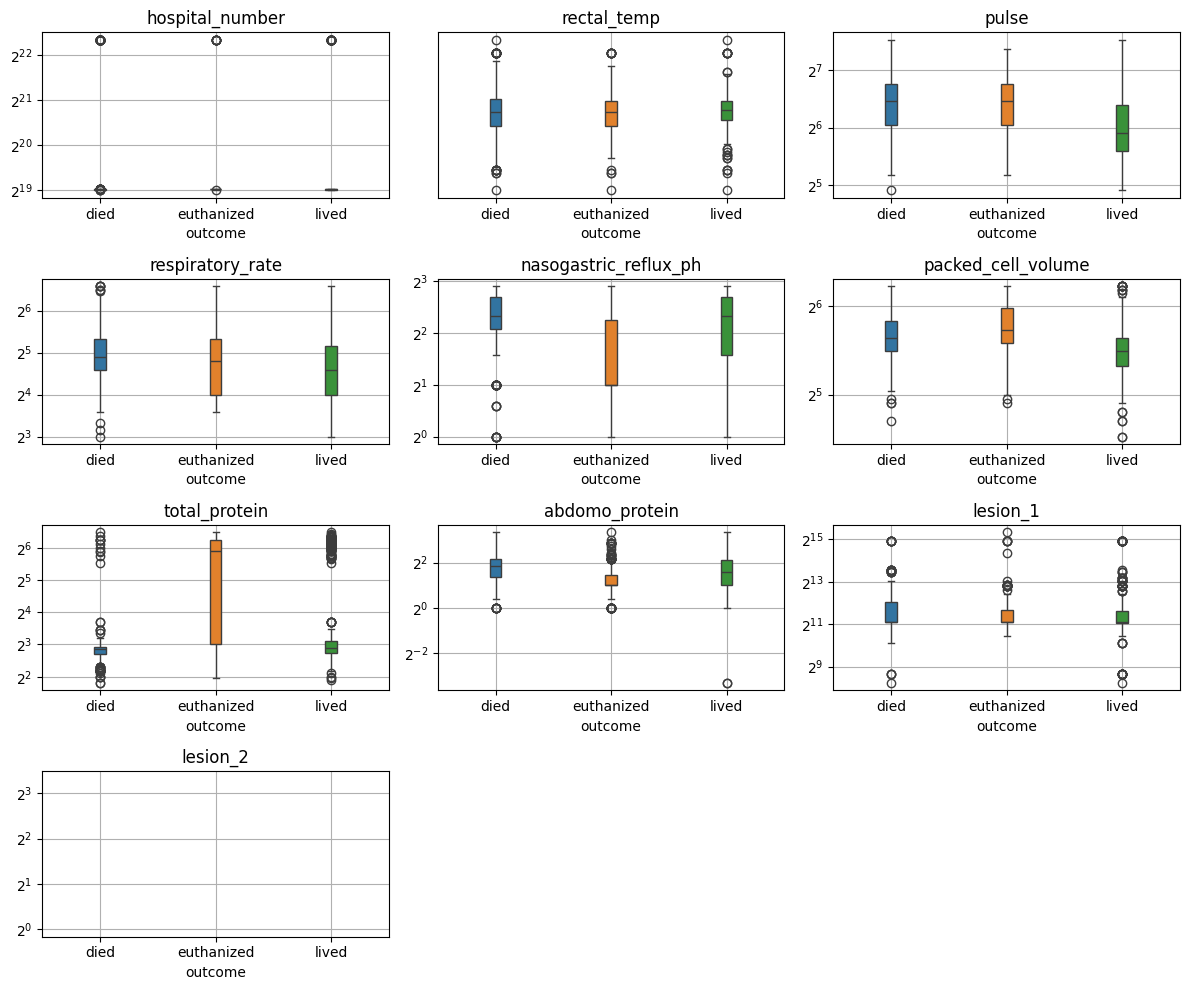

In [8]:
fig, sub = plt.subplots(4,3,figsize=(12, 10))
sub_arr = sub.flatten()

for i, sub_plot in enumerate(sub_arr):
     
    if i<len(numerical_feats[:-1]):
        tmp_data = train_data[[numerical_feats[i], "outcome"]]    
        tmp_data_pivot = pd.pivot(data=tmp_data, columns="outcome", values=numerical_feats[i])
        sns.boxplot(
            data=tmp_data_pivot,
            ax = sub_plot,
            width = 0.1,
            log_scale = 2
        )
        sub_plot.set_title(f"{numerical_feats[i]}")
        sub_plot.grid()
        
    else:
        sub_plot.set_visible(False)
        sub_plot.grid()
        
    

    
fig.tight_layout()   

In [9]:
np.round(train_data.pivot_table(index = "outcome", values=numerical_feats, aggfunc="mean", margins=True),2)

,abdomo_protein,hospital_number,lesion_1,lesion_2,lesion_3,nasogastric_reflux_ph,packed_cell_volume,pulse,rectal_temp,respiratory_rate,total_protein
outcome,,,,,,,,,,,
died,3.70,1226071.50,3918.62,0.00,0.00,5.00,51.49,90.21,38.21,34.05,8.88
euthanized,2.57,684220.80,3487.72,34.71,8.80,3.06,54.23,86.57,38.15,30.24,44.21
lived,3.32,878709.52,3921.74,16.26,3.85,4.52,46.23,68.92,38.22,27.12,20.35
All,3.29,954500.40,3832.50,14.61,3.58,4.38,49.60,79.57,38.20,30.05,21.39


Summary:<br>
* rectal_temp: no difference in mean observable
* pulse: horses with lower pulse tend to survive
* respiratory_rate: horses with higher rate tend to die
* packed_cell_volume: horses with higher cell volume (dehydrated) tend to die

# Correlation Analysis

### Numerical Features

<Axes: >

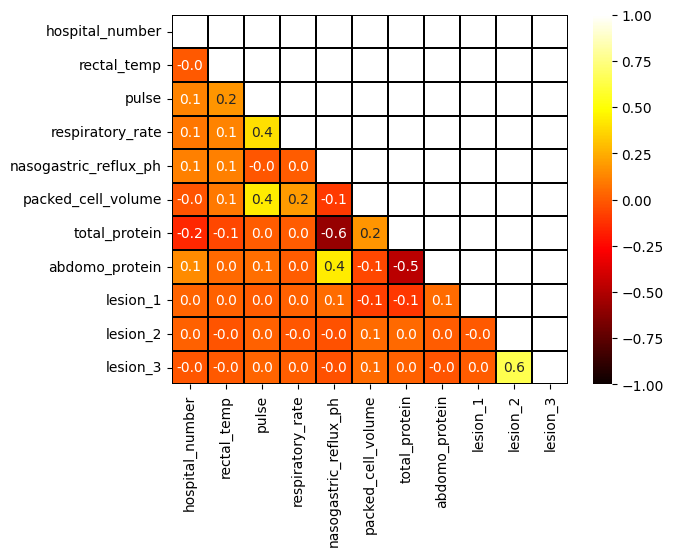

In [10]:
up_triang = np.triu(np.ones_like(train_data[numerical_feats].corr())).astype(bool)

sns.heatmap(
    train_data[numerical_feats].corr(),
    linewidth=0.1,
    linecolor="black",
    robust=True,
    mask=up_triang,
    vmin=-1,
    vmax=1,
    cmap='hot',
    annot=True,
    fmt=".1f"
    )

In [11]:
numerical_correlation = np.array([])

for x in numerical_feats: 
    
    for y in numerical_feats:
        
        corr_result = pearsonr(train_data[x], train_data[y])
        corr_coeff = np.round(corr_result[0], 2)
        p_value = np.round(corr_result[1], 2)
        
        tmp_arr = np.array([x, y, corr_coeff, p_value])
        
        if len(numerical_correlation)==0:
            numerical_correlation = tmp_arr
        else:
            numerical_correlation = np.vstack([numerical_correlation, tmp_arr])

corr_table = pd.DataFrame(numerical_correlation, columns = ["Feat_1", "Feat_2", "Corr_Coeff", "P_value"])  
corr_table["P_value"] = corr_table["P_value"].astype("float")

corr_table[corr_table["P_value"]<0.05]        

,Feat_1,Feat_2,Corr_Coeff,P_value
0,hospital_number,hospital_number,1.0,0.00
2,hospital_number,pulse,0.12,0.00
3,hospital_number,respiratory_rate,0.09,0.00
4,hospital_number,nasogastric_reflux_ph,0.11,0.00
6,hospital_number,total_protein,-0.15,0.00
7,hospital_number,abdomo_protein,0.14,0.00
12,rectal_temp,rectal_temp,1.0,0.00
13,rectal_temp,pulse,0.18,0.00
14,rectal_temp,respiratory_rate,0.12,0.00
15,rectal_temp,nasogastric_reflux_ph,0.12,0.00


Summary: <br>

* rectal_temp / pulse: +0.2
* pulse / packed_cell_volume: +0.4
* pule / respiratory_rate: +0.4
* nasogastric_reflux_ph / abdomo_protein: +0.4
* nasogastric_reflux_ph / total_protein: -0.6
* total_protein / abdomo_protein: -0.5
* lesion_2 / lesion_3: +0.6

### Categorical Features

In [12]:
train_data[categorical_feats].astype("category").apply(lambda x: x.cat.codes)

,surgery,age,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance,surgical_lesion,cp_data,outcome
0,1,0,1,3,2,2,1,0,3,2,0,1,1,2,1,0,0
1,1,0,1,2,4,2,3,0,0,0,1,0,1,2,1,0,1
2,1,0,1,3,5,1,2,3,0,2,2,-1,0,2,1,0,2
3,1,0,0,3,5,2,3,3,0,2,1,1,1,1,1,1,2
4,0,0,2,2,3,1,0,3,1,2,0,3,3,1,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,1,0,1,3,5,2,1,0,0,0,1,-1,0,2,1,0,2
1231,1,0,1,3,4,1,3,3,3,2,2,1,1,2,1,1,0
1232,1,1,2,3,3,1,3,3,3,2,2,2,2,1,1,1,2
1233,1,0,2,3,1,1,3,3,3,0,1,0,1,1,1,0,2


In [13]:
X = train_data[categorical_feats].drop("outcome", axis = 1).astype("category")
X = X.apply(lambda x: x.cat.codes)
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

y = train_data["outcome"].astype("category")

In [14]:
selection = SelectKBest(score_func=chi2, k = "all")

selection.fit(X_scaled, y)

chi2_result = pd.DataFrame({
    "variable": X_scaled.columns,
    "chi2_stat": selection.scores_,
    "p_value": selection.pvalues_}).sort_values(by="p_value", ascending = True)

chi2_result

,variable,chi2_stat,p_value
1,age,51.999358,5.110729e-12
15,cp_data,36.687580,1.079924e-08
14,surgical_lesion,22.352114,1.400555e-05
13,abdomo_appearance,13.754890,1.030774e-03
7,peristalsis,12.423932,2.005291e-03
11,rectal_exam_feces,10.323541,5.731542e-03
0,surgery,8.919798,1.156353e-02
12,abdomen,6.936575,3.117036e-02
2,temp_of_extremities,6.289933,4.306838e-02
8,abdominal_distention,6.230035,4.437773e-02


In [15]:
chi2_result["p_value"] = chi2_result["p_value"].astype("float")
relevant_features = chi2_result[chi2_result["p_value"]<0.05]["variable"].values

In [16]:
categorical_correlation = np.array([])

for feat in relevant_features:
    
    cont_table = pd.crosstab(index = train_data[feat], columns = train_data["outcome"])
    X2_result = scs.chi2_contingency(cont_table)[0]
    N = len(train_data)
    degrees_of_freedom = min(cont_table.shape)-1
    result = np.sqrt((X2_result/N)/degrees_of_freedom)
    
    tmp_arr = np.array([feat, np.round(result, 2), degrees_of_freedom])
    
    if len(categorical_correlation)==0:
        categorical_correlation = tmp_arr
    else:
        categorical_correlation = np.vstack([categorical_correlation, tmp_arr])
        
cramers_V = pd.DataFrame(categorical_correlation, columns = ["Features", "Correlation", "df"]).sort_values(by="Correlation", ascending = False)

cramers_V

,Features,Correlation,df
2,surgical_lesion,0.27,1
3,abdomo_appearance,0.26,2
1,cp_data,0.25,1
8,temp_of_extremities,0.24,2
4,peristalsis,0.23,2
9,abdominal_distention,0.23,2
0,age,0.21,1
7,abdomen,0.18,2
5,rectal_exam_feces,0.16,2
6,surgery,0.16,1


In [17]:
cramers_V["Features"].values

array(['surgical_lesion', 'abdomo_appearance', 'cp_data',
       'temp_of_extremities', 'peristalsis', 'abdominal_distention',
       'age', 'abdomen', 'rectal_exam_feces', 'surgery',
       'nasogastric_tube'], dtype=object)

# Analysis Hospital_number Feature

In [18]:
hospital_no = pd.crosstab(index=train_data["hospital_number"], columns=train_data["outcome"], margins = True)
hospital_no.sort_values("died", ascending=False).head(20)

outcome,died,euthanized,lived,All
hospital_number,,,,
All,410,251,574,1235
529461,31,12,3,46
5290409,19,0,1,20
528469,12,0,7,19
5287179,11,0,5,16
527563,11,0,5,16
530001,9,5,1,15
528743,9,1,3,13
530693,9,1,4,14


In [19]:
hospital_no[(hospital_no["died"]>1)|(hospital_no["euthanized"]>1)]

outcome,died,euthanized,lived,All
hospital_number,,,,
521399,2,1,0,3
527365,7,1,3,11
527463,5,0,7,12
527518,2,1,2,5
527524,2,0,2,4
...,...,...,...,...
5290759,2,0,3,5
5297159,3,1,0,4
5297379,3,0,1,4


# Analysis Lesion Features

In [20]:
train_data.groupby(train_data["lesion_1"].astype("str").str[3])["outcome"].value_counts()

lesion_1  outcome   
0         died           76
          euthanized     40
          lived          37
1         lived         118
          died           33
          euthanized     25
2         lived          28
          died           20
          euthanized      3
3         lived          29
          euthanized      7
          died            4
4         lived          53
          died            7
          euthanized      2
5         died          133
          euthanized     77
          lived          74
6         lived          23
          died           14
          euthanized      7
7         died           12
          euthanized     12
          lived           9
8         lived          62
          died           57
          euthanized     33
9         died           46
          lived          42
          euthanized     41
Name: count, dtype: int64

# Analysis rectal_temp

In [21]:
train_data[["rectal_temp", "outcome"]].groupby("outcome")["rectal_temp"].mean()

outcome
died          38.211220
euthanized    38.153785
lived         38.216899
Name: rectal_temp, dtype: float64

# Analysis packed cell volume

In [22]:
buffer = train_data[["packed_cell_volume", "outcome"]]
buffer["packed_cell_vol_cat"] = pd.cut(buffer["packed_cell_volume"], bins = 7)
np.round(buffer.groupby("packed_cell_vol_cat")["outcome"].value_counts(normalize=True),2)

packed_cell_vol_cat  outcome   
(22.948, 30.429]     lived         0.73
                     died          0.20
                     euthanized    0.07
(30.429, 37.857]     lived         0.61
                     died          0.22
                     euthanized    0.18
(37.857, 45.286]     lived         0.64
                     died          0.29
                     euthanized    0.07
(45.286, 52.714]     lived         0.46
                     died          0.33
                     euthanized    0.21
(52.714, 60.143]     died          0.44
                     euthanized    0.28
                     lived         0.28
(60.143, 67.571]     euthanized    0.40
                     died          0.36
                     lived         0.24
(67.571, 75.0]       died          0.40
                     euthanized    0.32
                     lived         0.28
Name: proportion, dtype: float64

# Naive Prediction (Predict strictly one value)

In [51]:
naive_prediction = pd.Series(len(train_data["outcome"])*[1])
naive_prediction = naive_prediction.astype("category").cat.codes
y_true = train_data["outcome"].astype("category").cat.codes

from sklearn.metrics import accuracy_score, recall_score, precision_score

acc_score = accuracy_score(y_true = y_true, y_pred = naive_prediction)
precision = precision_score(
    y_true=y_true, y_pred=naive_prediction, average="macro")
recall = recall_score(y_true=y_true, y_pred=naive_prediction, average="macro")

print(f"Accuracy Score: {acc_score}")
print(f"Precision Score: {precision}")
print(f"Recall Score: {recall}")

Accuracy Score: 0.3319838056680162
Precision Score: 0.1106612685560054
Recall Score: 0.3333333333333333


In [25]:
pd.read_csv(RAW_DATA_PATH + "/horse.csv")

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,...,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,...,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,...,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,...,74.0,7.4,NaN,NaN,died,no,4300,0,0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,yes,adult,533886,NaN,120.0,70.0,cold,NaN,pale_cyanotic,more_3_sec,...,55.0,65.0,NaN,NaN,euthanized,no,3205,0,0,no
295,no,adult,527702,37.2,72.0,24.0,cool,increased,pale_cyanotic,more_3_sec,...,44.0,NaN,serosanguious,3.3,euthanized,yes,2208,0,0,yes
296,yes,adult,529386,37.5,72.0,30.0,cold,reduced,pale_cyanotic,less_3_sec,...,60.0,6.8,NaN,NaN,died,yes,3205,0,0,no
297,yes,adult,530612,36.5,100.0,24.0,cool,reduced,pale_pink,less_3_sec,...,50.0,6.0,serosanguious,3.4,lived,yes,2208,0,0,yes
